In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [11]:
def show_tensor_images(image_tensor, n_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2 # Normalization
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:n_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
    
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
        
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, im_chan=1, hidden_dim=16):
        super().__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
        )
    
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
        
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
loss_fn = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15518154.25it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 459529.66it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 894928.42it/s] 


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2291103.88it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize weights such that they are in a normal distribution with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500| Generator loss: 1.4769294838756315 | Discriminator loss: 0.4427928790748117


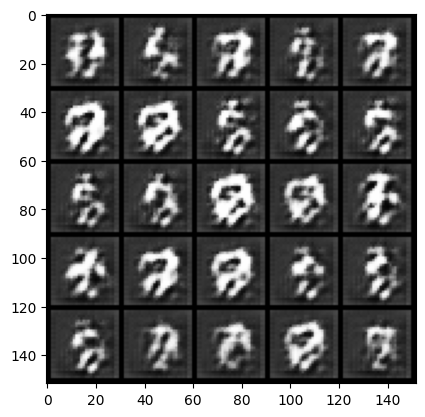

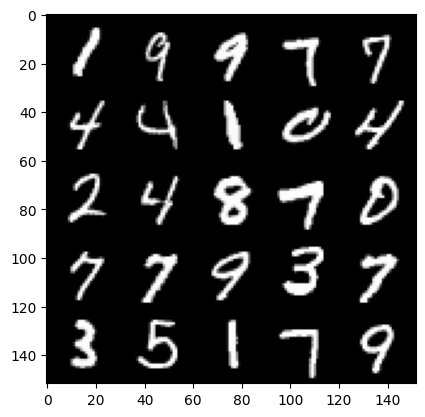

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000| Generator loss: 1.2499881381094455 | Discriminator loss: 0.4792328863739967


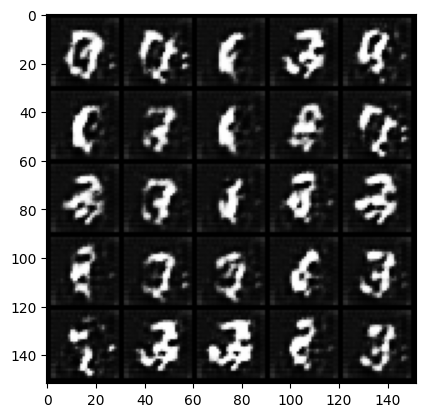

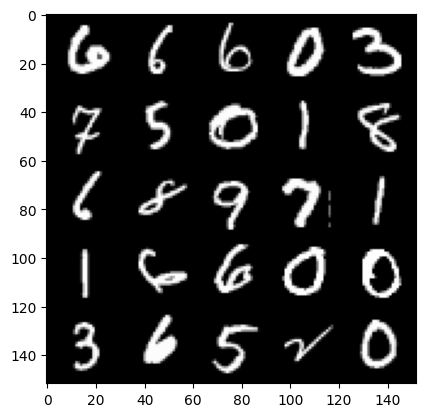

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500| Generator loss: 1.0050077203810213 | Discriminator loss: 0.5556834056377412


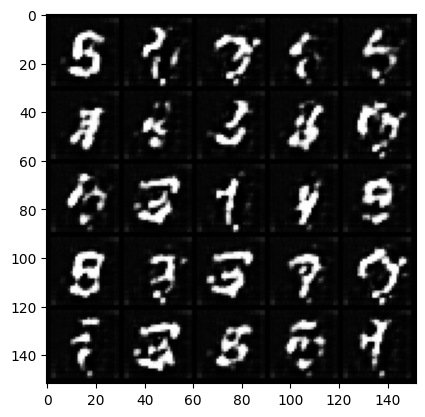

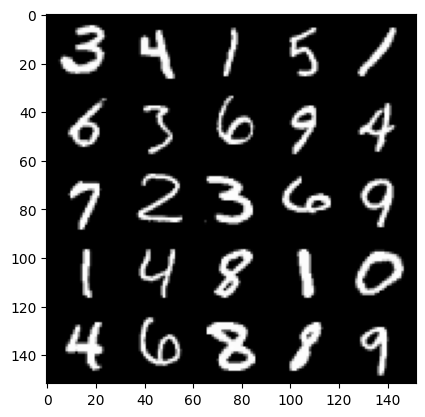

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000| Generator loss: 0.9120843758583066 | Discriminator loss: 0.5904345730543132


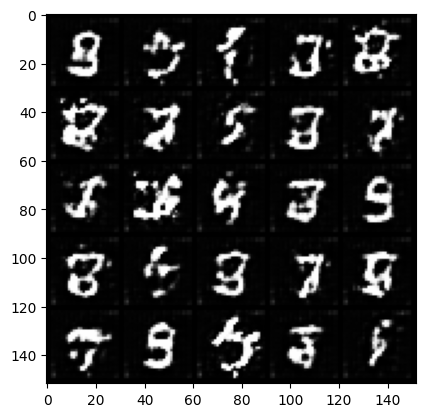

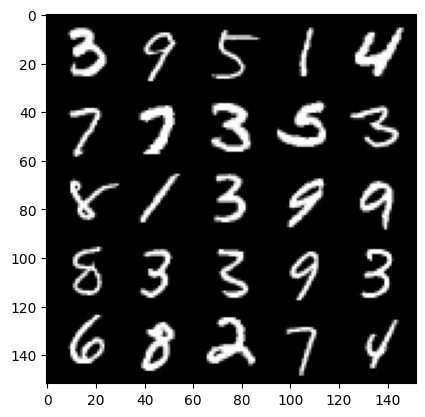

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500| Generator loss: 0.8721487431526181 | Discriminator loss: 0.6081102561950681


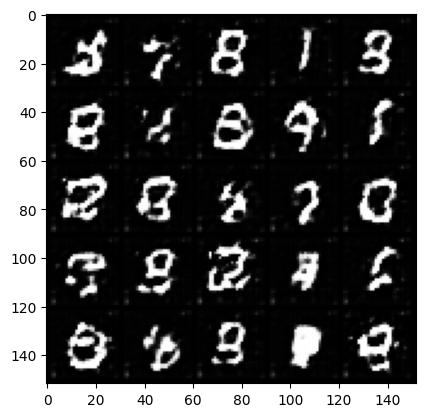

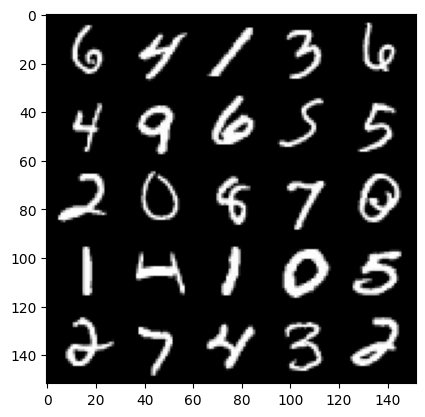

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000| Generator loss: 0.854833577394486 | Discriminator loss: 0.6222097668647768


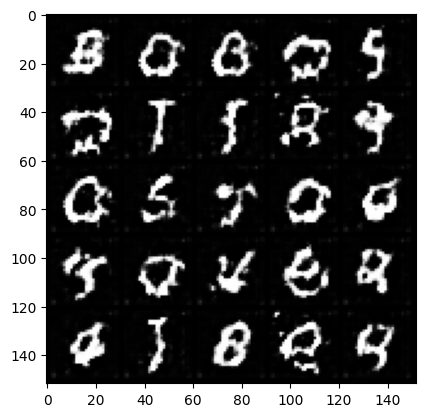

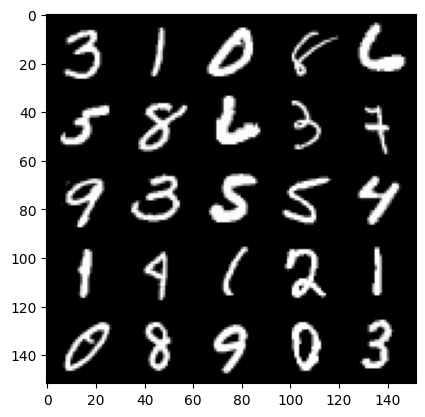

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500| Generator loss: 0.8504509042501441 | Discriminator loss: 0.6237217397689822


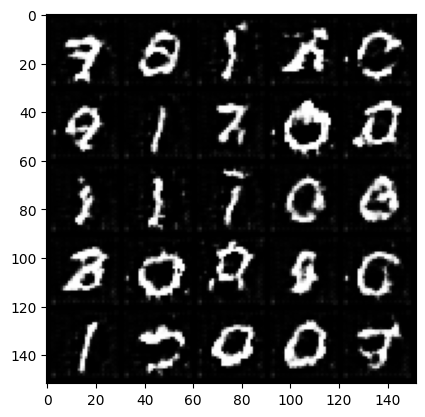

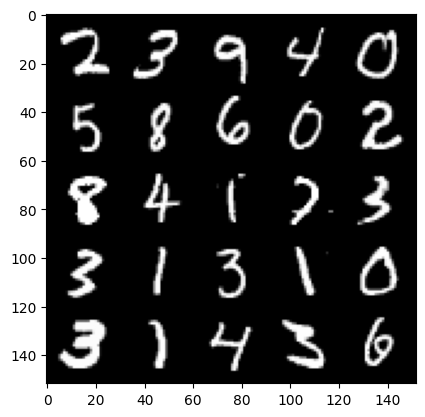

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000| Generator loss: 0.8603896034955976 | Discriminator loss: 0.6213717712163924


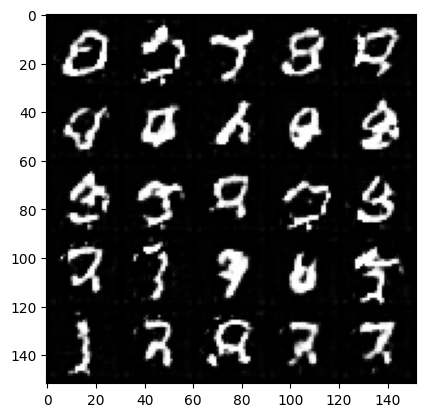

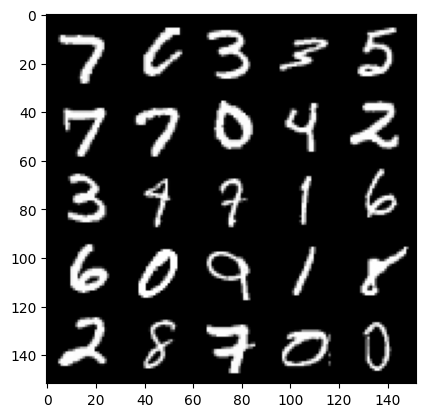

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500| Generator loss: 0.8442300332188607 | Discriminator loss: 0.6331150007247922


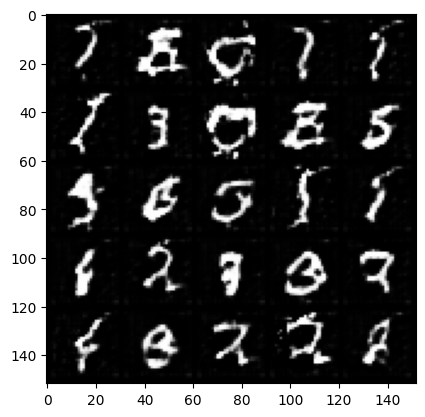

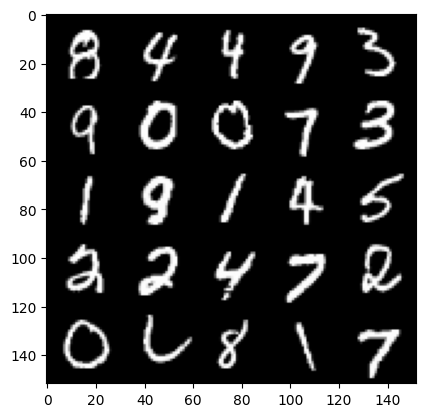

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000| Generator loss: 0.8276955904364593 | Discriminator loss: 0.6455859048366548


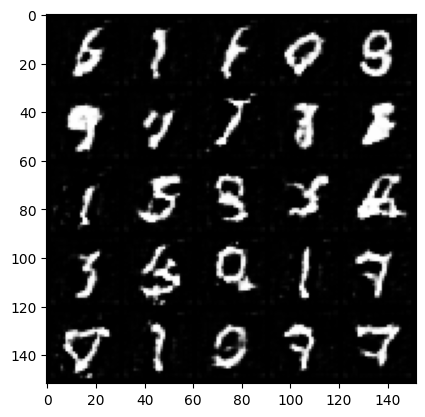

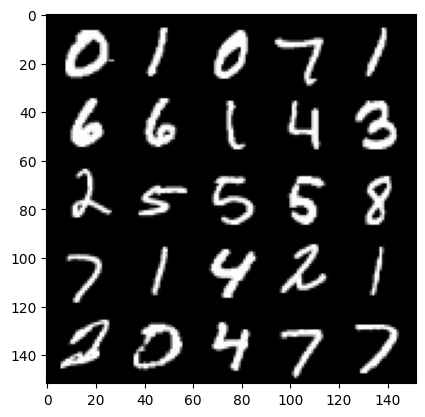

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500| Generator loss: 0.8035964703559884 | Discriminator loss: 0.6552925428152082


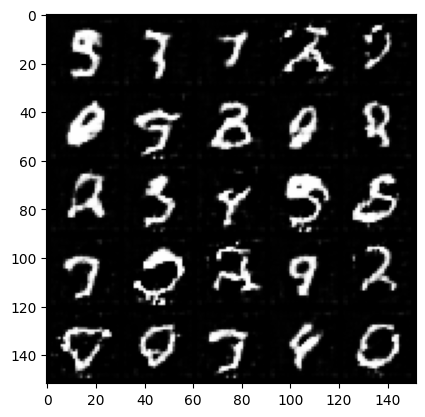

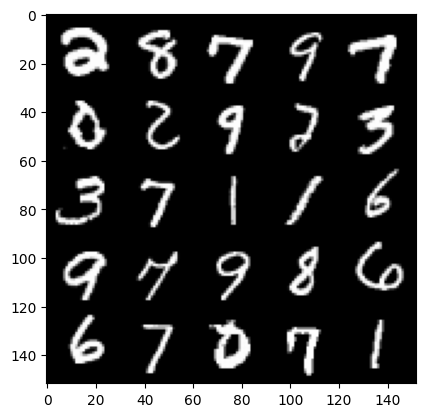

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000| Generator loss: 0.7920860834717752 | Discriminator loss: 0.6614408060312272


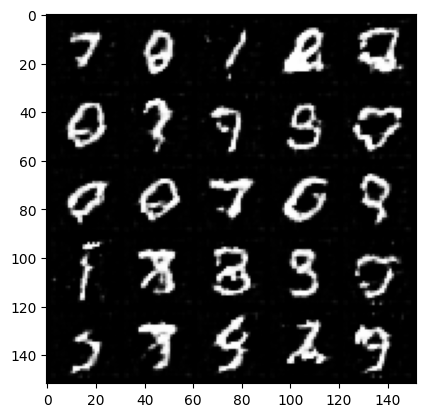

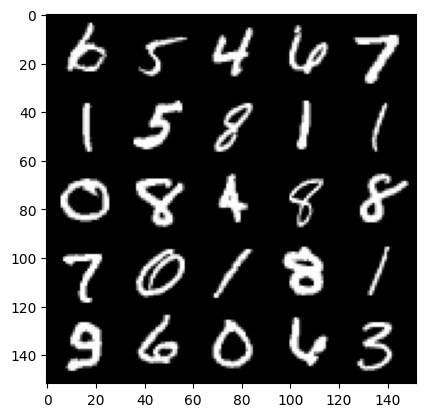

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500| Generator loss: 0.7790038614273067 | Discriminator loss: 0.6665113533735275


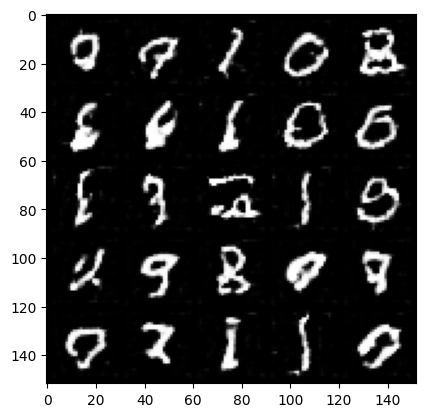

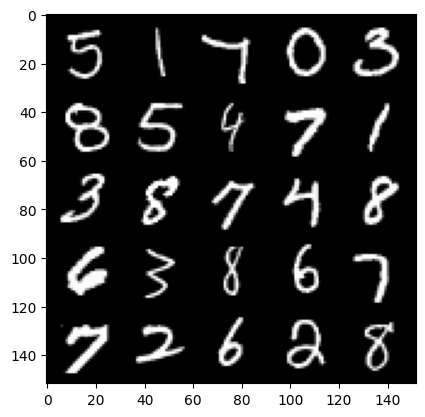

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000| Generator loss: 0.7734721304178241 | Discriminator loss: 0.6693382650613783


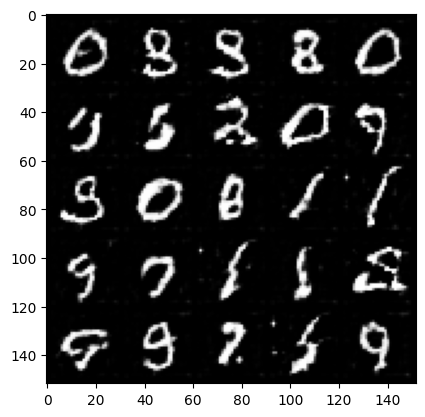

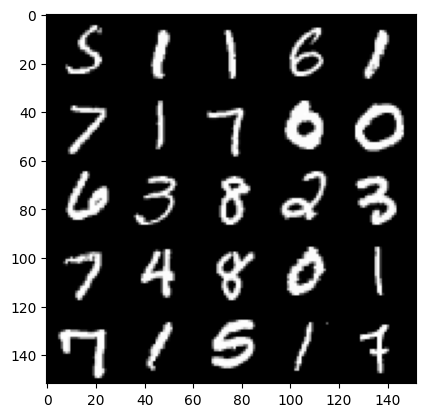

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500| Generator loss: 0.7633992376327513 | Discriminator loss: 0.6771574906110766


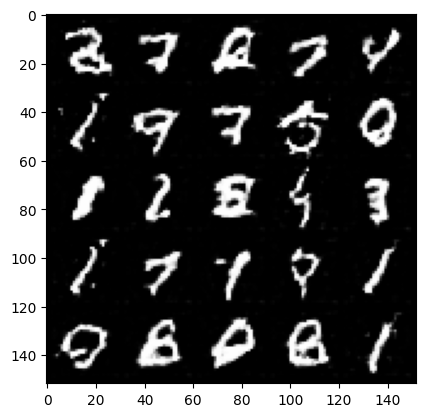

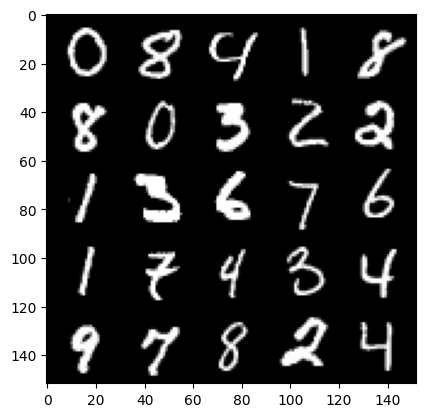

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000| Generator loss: 0.7531277239322665 | Discriminator loss: 0.6814676983356478


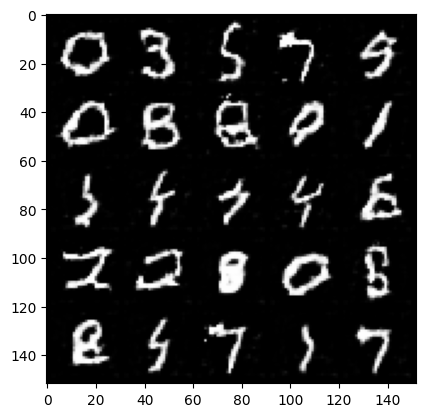

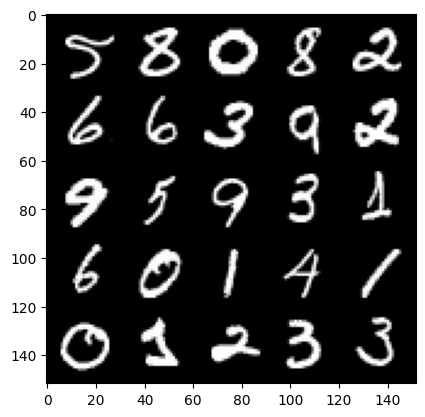

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500| Generator loss: 0.746809773921966 | Discriminator loss: 0.6864271463155744


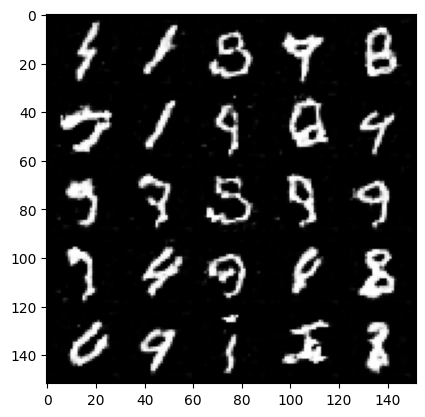

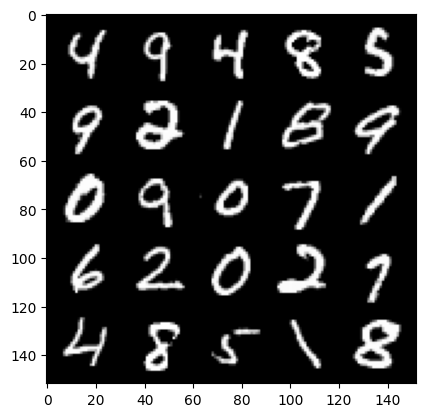

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000| Generator loss: 0.7372699928283681 | Discriminator loss: 0.6903728138208386


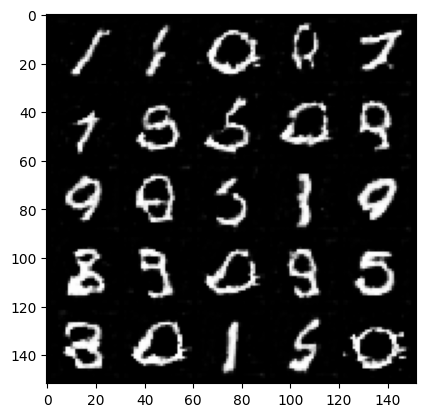

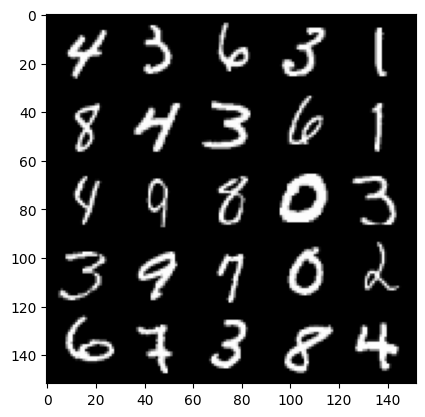

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500| Generator loss: 0.7307745552062984 | Discriminator loss: 0.6923976176977158


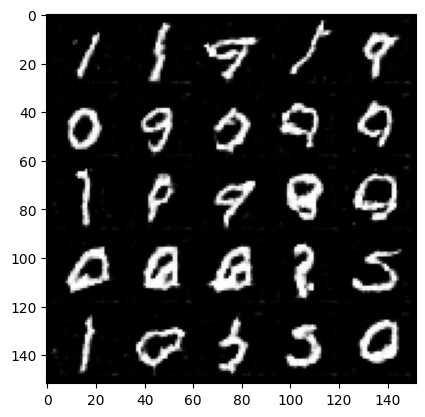

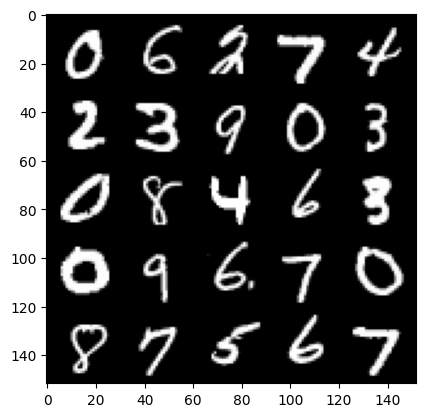

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000| Generator loss: 0.7269649431705479 | Discriminator loss: 0.6938194347620011


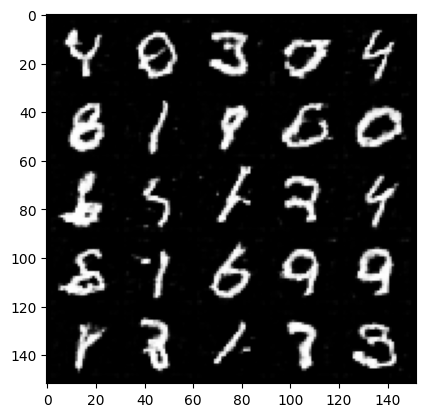

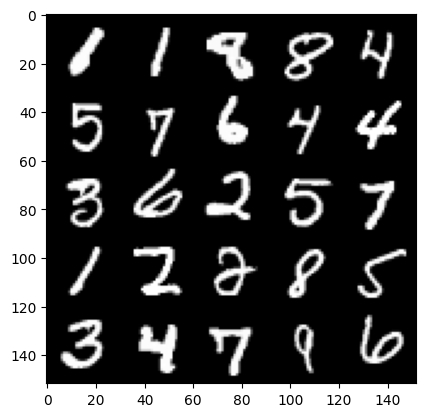

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500| Generator loss: 0.7227467532157895 | Discriminator loss: 0.6939874317646021


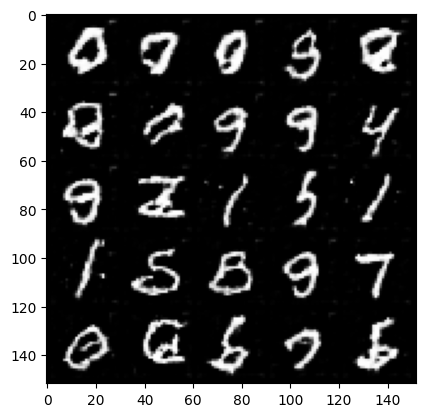

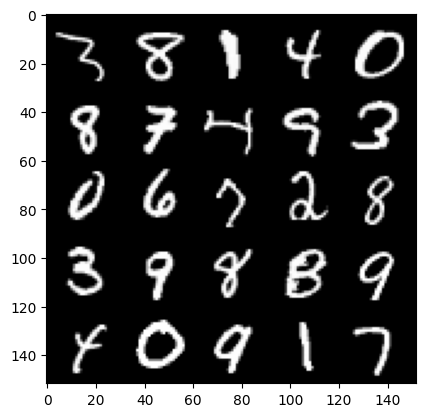

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000| Generator loss: 0.7186032192707063 | Discriminator loss: 0.6953730115890503


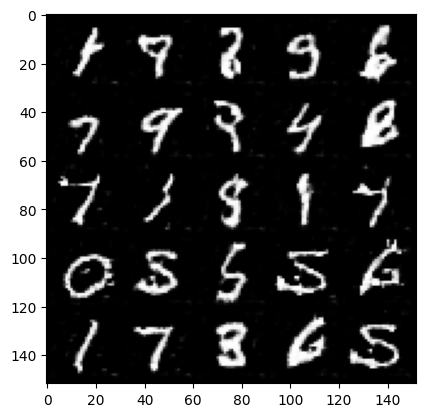

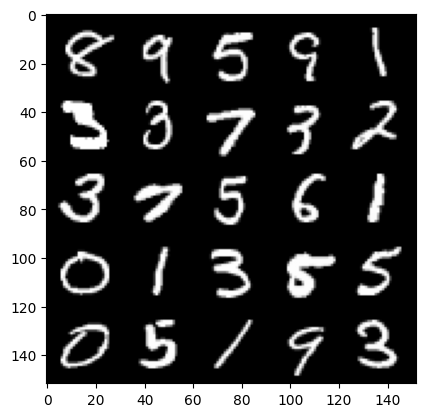

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500| Generator loss: 0.7185502389669426 | Discriminator loss: 0.69613069498539


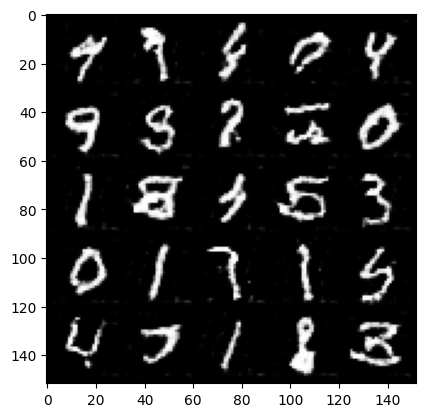

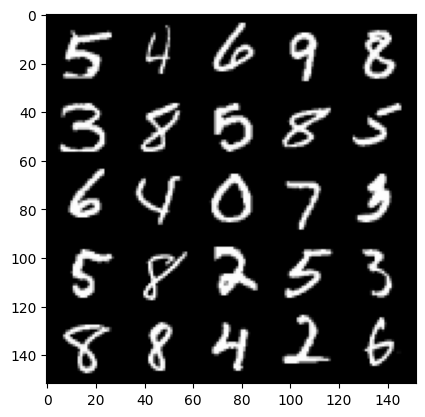

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000| Generator loss: 0.7136058394908905 | Discriminator loss: 0.696888539671898


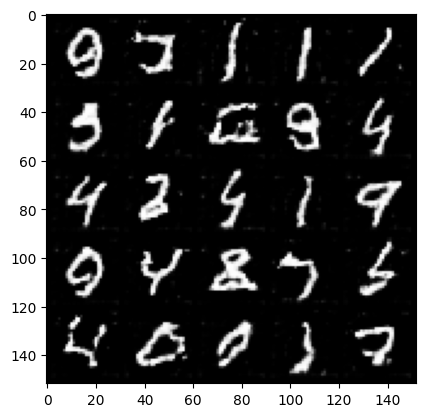

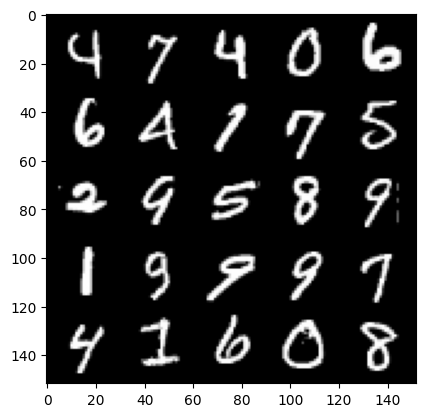

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500| Generator loss: 0.7108479205369954 | Discriminator loss: 0.6964702483415599


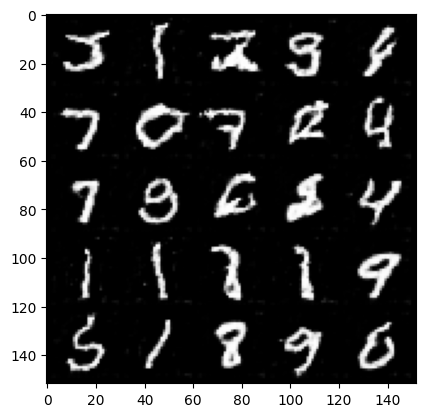

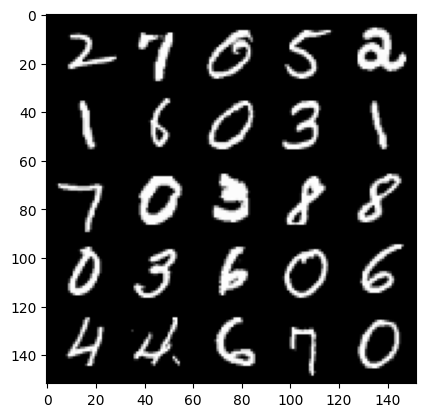

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000| Generator loss: 0.7126586066484457 | Discriminator loss: 0.6980690571069722


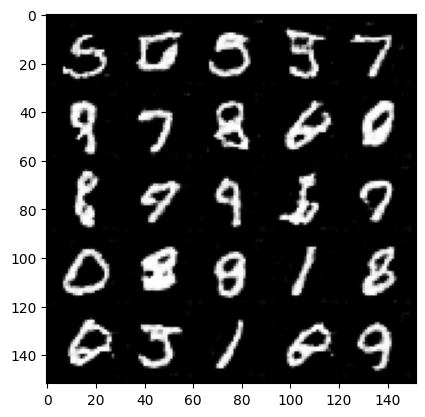

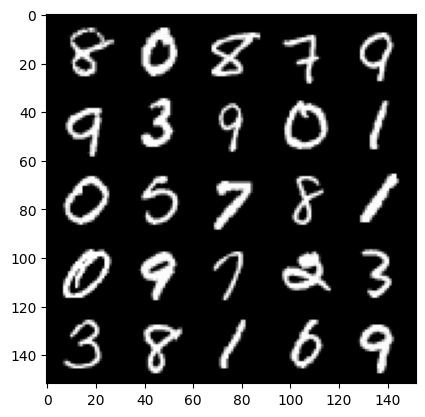

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500| Generator loss: 0.7076679620742793 | Discriminator loss: 0.6977870604991913


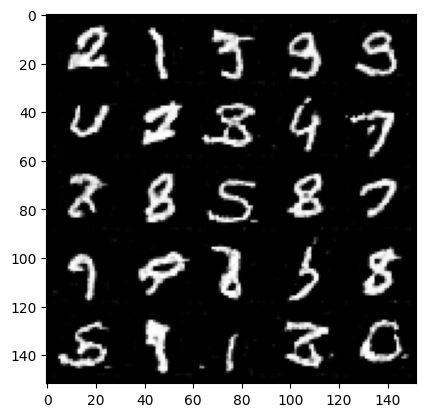

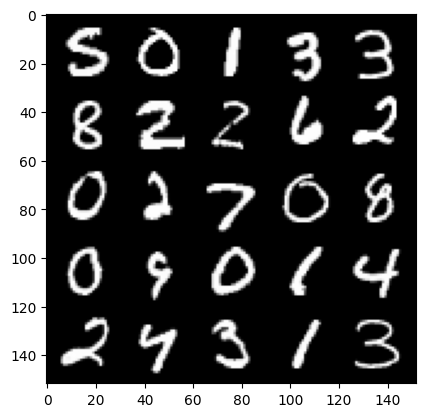

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000| Generator loss: 0.7072921082973488 | Discriminator loss: 0.6983200393915185


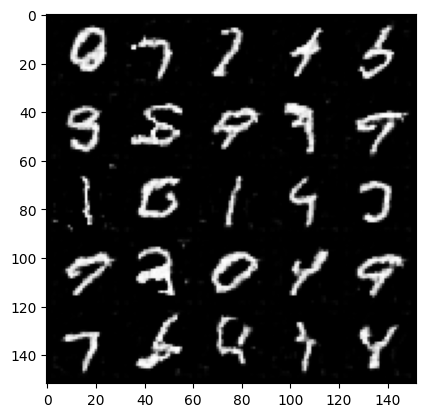

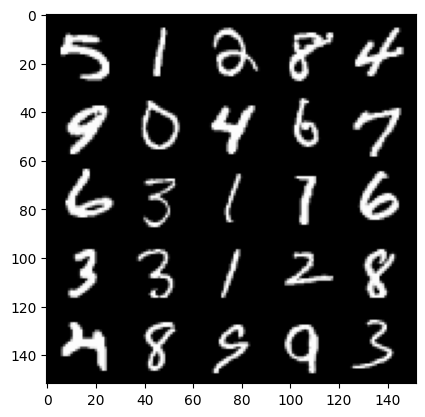

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500| Generator loss: 0.7045899823904037 | Discriminator loss: 0.6989711483716962


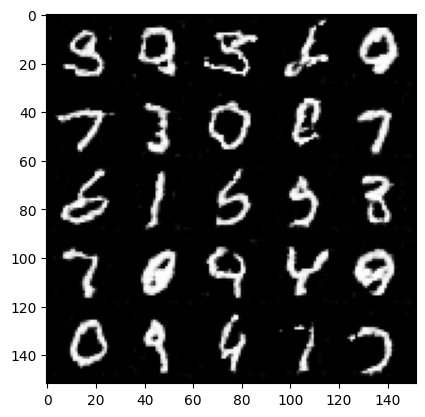

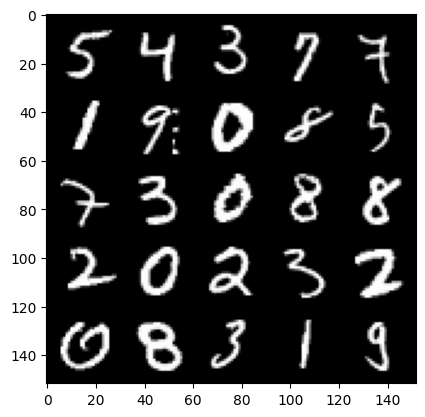

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000| Generator loss: 0.7008339287042614 | Discriminator loss: 0.698957199692726


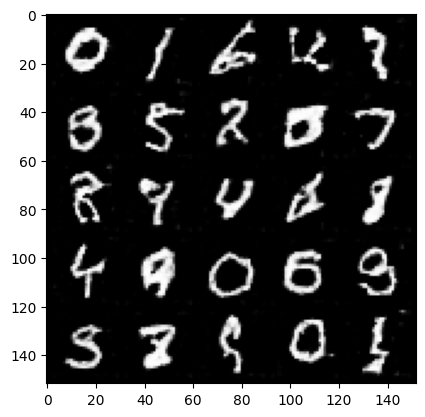

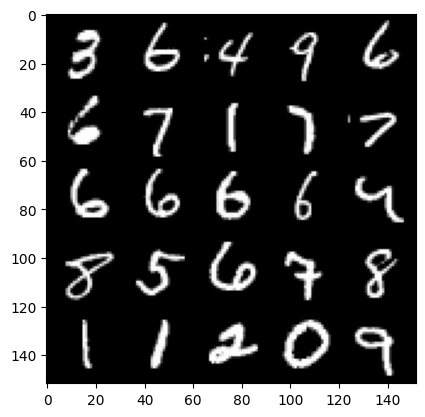

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500| Generator loss: 0.7020678077936175 | Discriminator loss: 0.6988241963386538


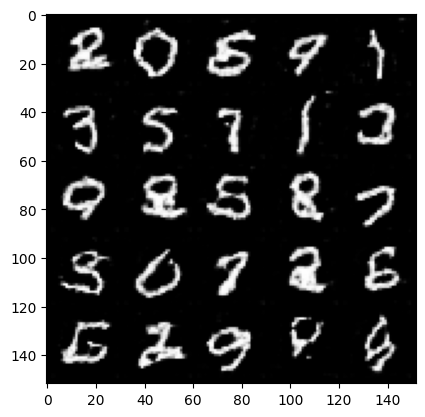

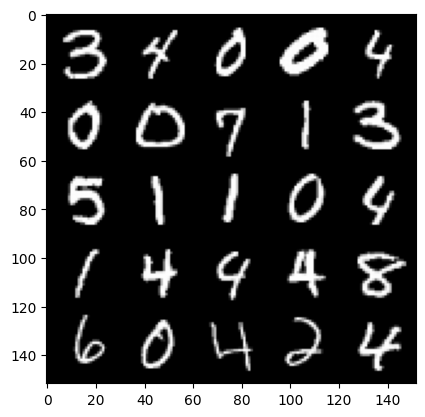

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000| Generator loss: 0.7015846837759021 | Discriminator loss: 0.6986098639965059


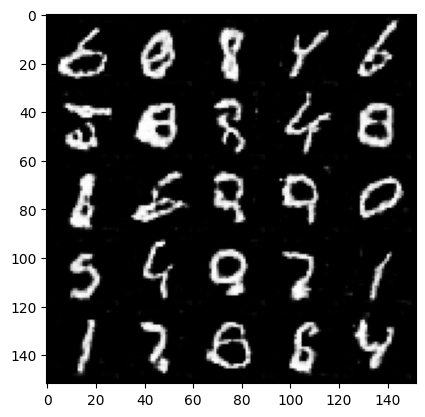

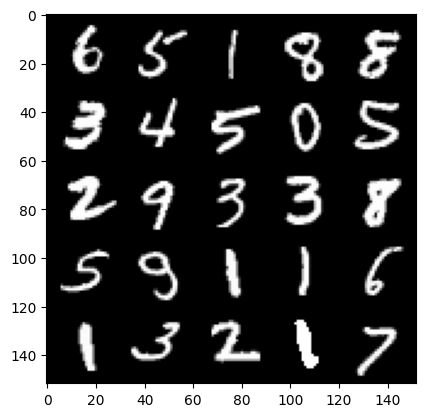

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500| Generator loss: 0.6984454674720757 | Discriminator loss: 0.6985239164829253


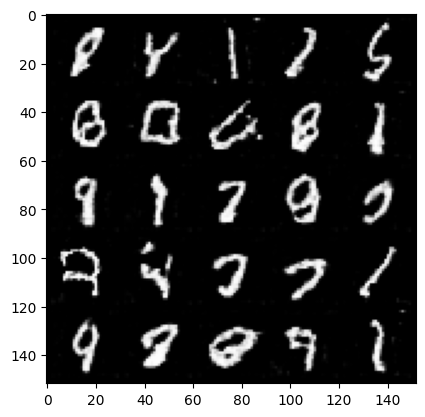

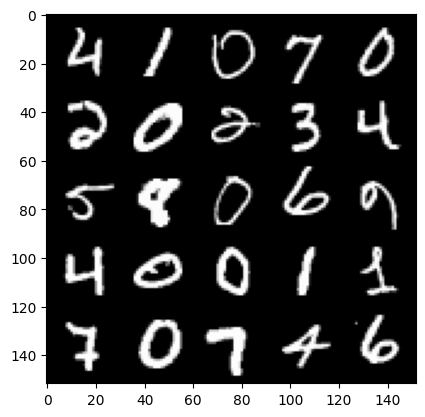

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000| Generator loss: 0.6992879199981687 | Discriminator loss: 0.6988822429180147


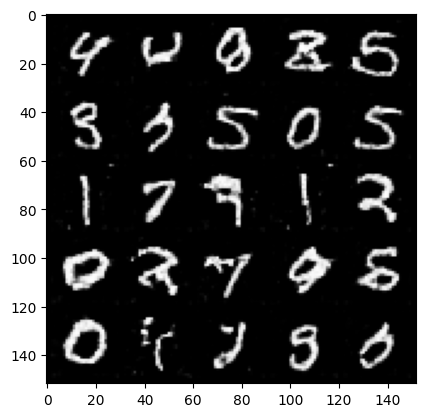

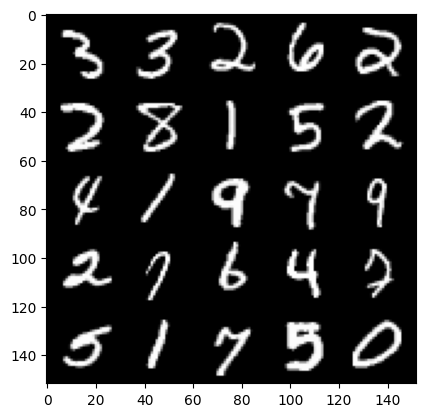

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500| Generator loss: 0.6977181301116943 | Discriminator loss: 0.6987081086635594


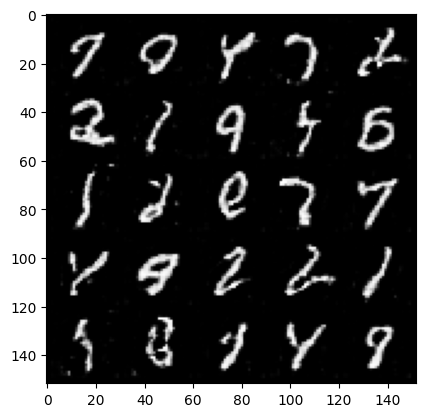

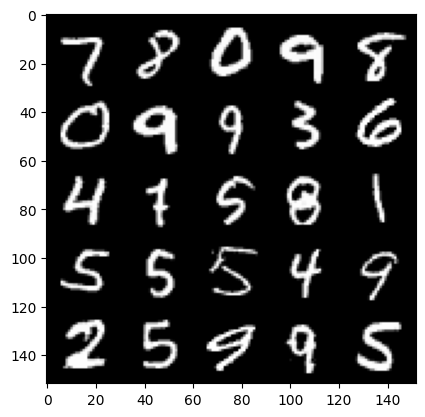

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000| Generator loss: 0.6966473804712298 | Discriminator loss: 0.6989757548570632


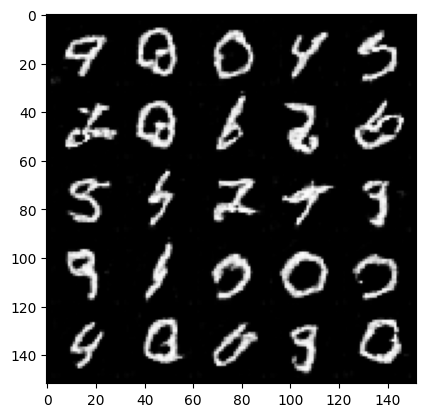

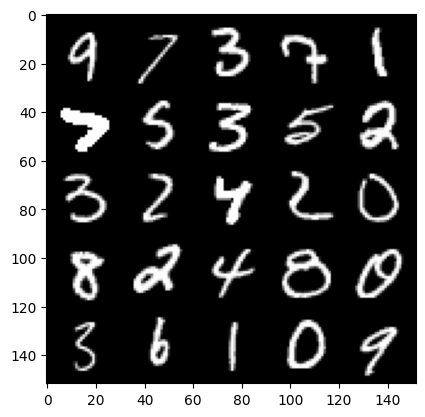

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500| Generator loss: 0.6963221787214284 | Discriminator loss: 0.6988153680562976


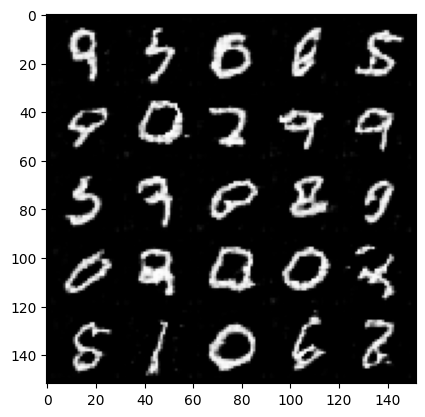

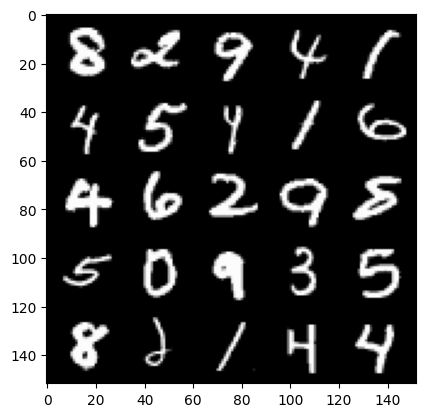

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000| Generator loss: 0.6972502964735033 | Discriminator loss: 0.6986845479011538


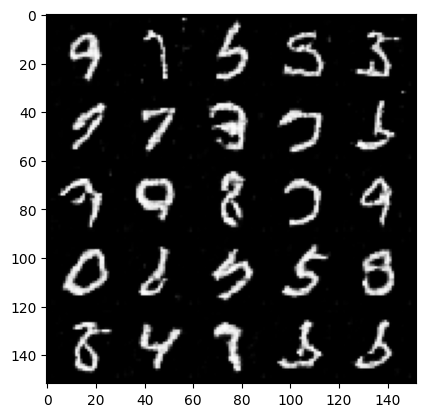

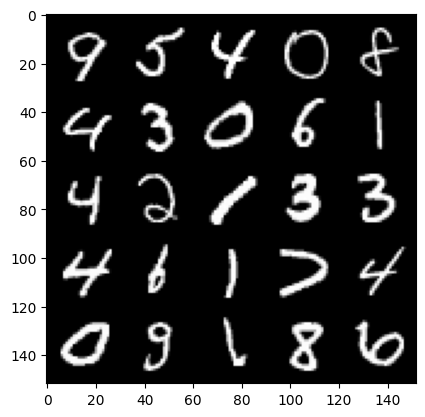

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500| Generator loss: 0.694933309316635 | Discriminator loss: 0.698357183456421


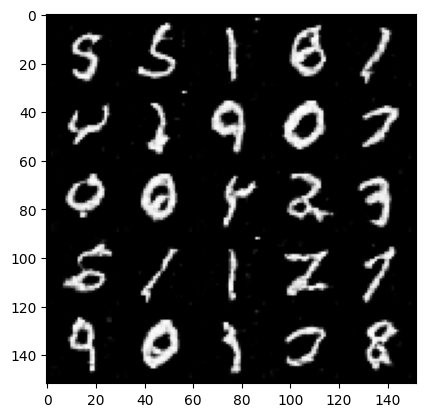

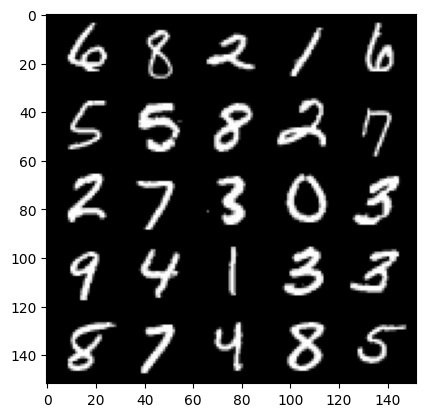

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000| Generator loss: 0.6964784544706348 | Discriminator loss: 0.6979449775218964


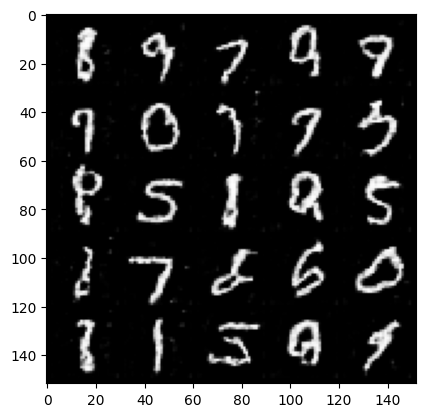

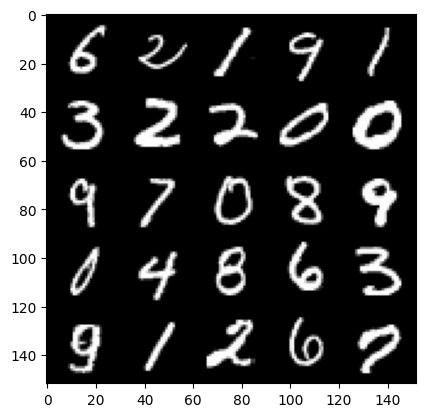

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500| Generator loss: 0.6981651211977002 | Discriminator loss: 0.6972836785316464


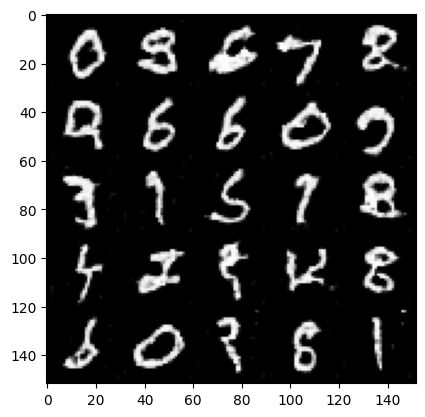

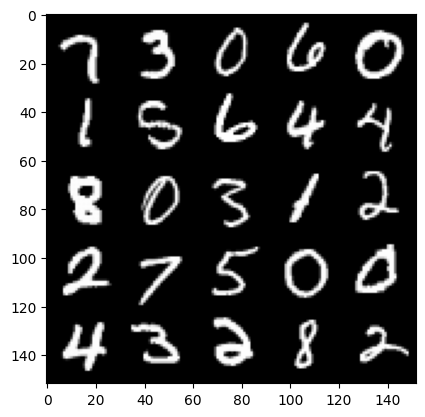

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000| Generator loss: 0.6944162193536756 | Discriminator loss: 0.6972415944337843


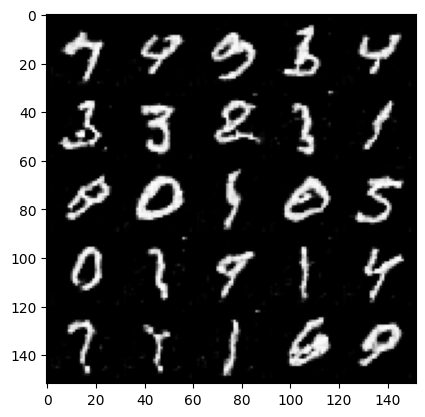

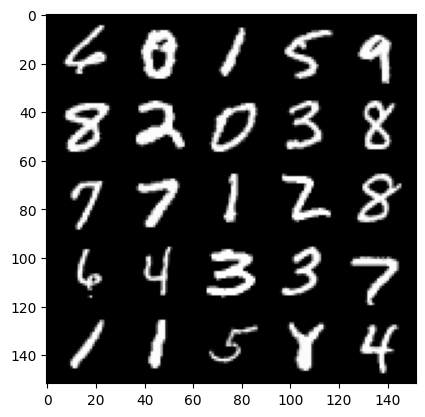

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500| Generator loss: 0.6961438349485397 | Discriminator loss: 0.6965453095436095


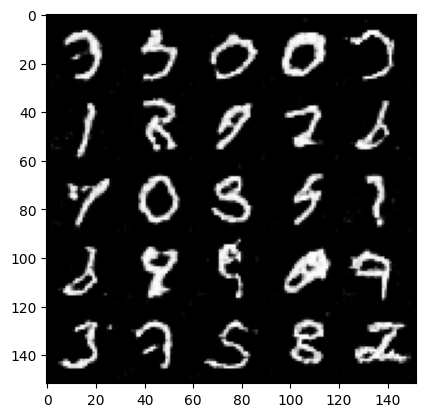

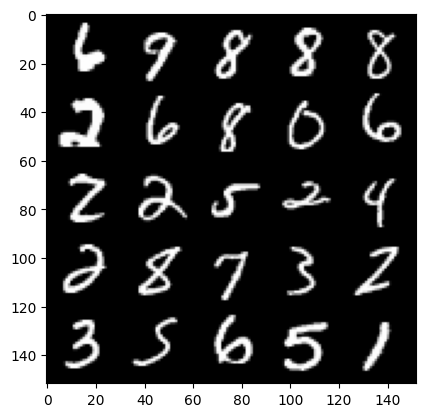

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000| Generator loss: 0.69599708712101 | Discriminator loss: 0.6967681025266647


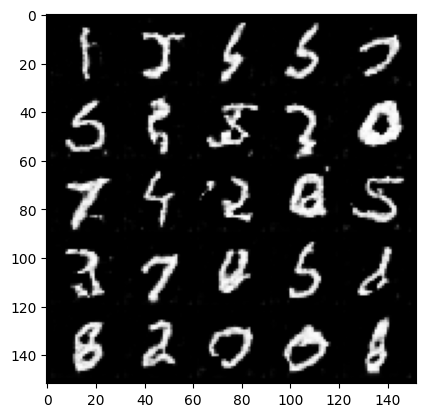

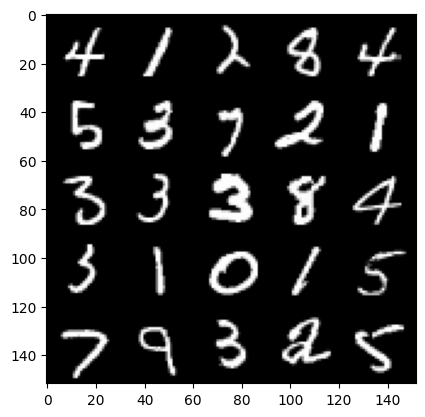

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500| Generator loss: 0.6971323945522307 | Discriminator loss: 0.6962659409046168


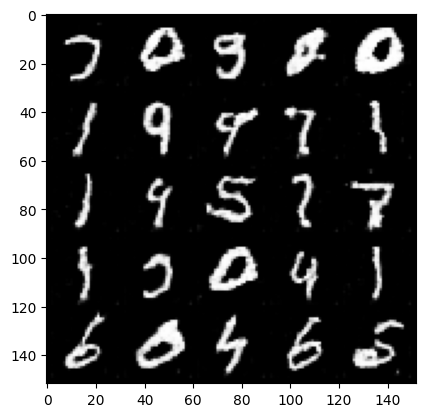

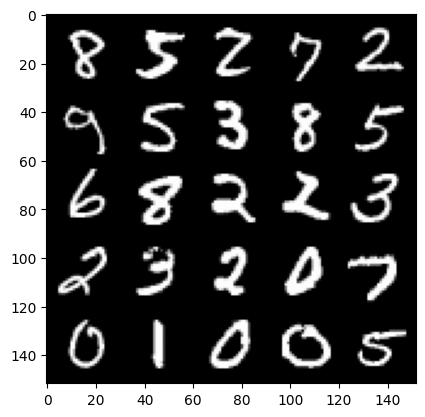

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000| Generator loss: 0.6956744444370273 | Discriminator loss: 0.6958984259366983


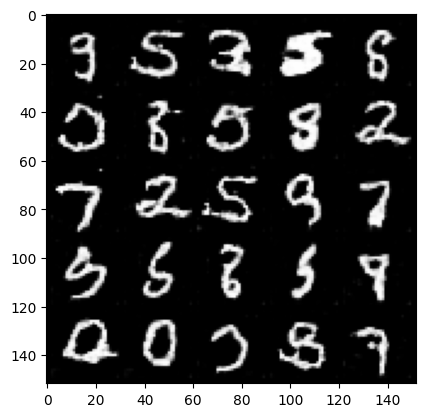

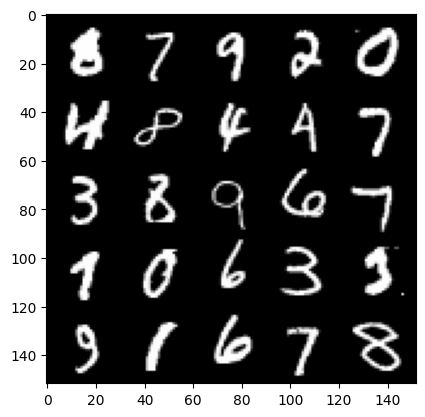

In [12]:
n_epochs = 50
cur_step = 0
mean_gen_loss, mean_disc_loss = 0.0, 0.0

for epoch in range(n_epochs):
    
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = loss_fn(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = loss_fn(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        mean_disc_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)  
        disc_opt.step()
        
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = loss_fn(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        mean_gen_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Step {cur_step}| Generator loss: {mean_gen_loss} | Discriminator loss: {mean_disc_loss}')
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_gen_loss, mean_disc_loss = 0.0, 0.0
        cur_step += 1

In [14]:
torch.save(gen.state_dict(), 'params_dcgan_gen_nb_1.pth')
torch.save(disc.state_dict(), 'params_dcgan_disc_nb_1.pth')